In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from tensorflow.keras.datasets import mnist
from sklearn.metrics.pairwise import euclidean_distances
import os

print('Все прошло успешно!')

Все прошло успешно!


In [2]:
data = fetch_olivetti_faces()
X = data.data  # матрица данных
images = data.images  # для визуализаций

In [3]:
X.shape

(400, 4096)

Датасет Olivetti Faces содержит $n = 400$ изображений.\
Каждое изображение представлено вектором

$$
x_i \in \mathbb{R}^{d}, \quad d = 4096.
$$

Матрица данных:

$$
X =
\begin{bmatrix}
x_1^T \\
\vdots \\
x_n^T
\end{bmatrix}
\in \mathbb{R}^{n \times d}
$$

представляет собой конечный набор точек
$\{x_1, \dots, x_n\} \subset \mathbb{R}^{4096}$.

$\mathbb{R}^{4096}$ же при этом - евклидово векторное пространство, элементы которого интерпретируются как изображения $64 \times 64$.

Шум, черный квадрат, "не лицо" - это тоже "изображение" в этом векторном пространстве.

Следующим шагом будет вычисление среднего вектора

$$
\mu = \frac{1}{n} \sum_{i=1}^n x_i,
$$

который является афинной комбинацией исходных данных
($\sum \lambda_i = 1$).

После чего делаем центрирование данных для каждого ${x_i}$:

$$
\tilde{x}_i = x_i - \mu,
$$

что переводит задачу поиска афинного подпространства в задачу поиска линейного подпространства.

Неформально это значит, что поиск лучшего афинного подпространства эквивалентен поиску лучшего линейного подпространства после центрирования.

In [4]:
mu = X.mean(axis=0)
mu.shape  # проверили размерность на всякий случай - мю должен быть вектором

(4096,)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

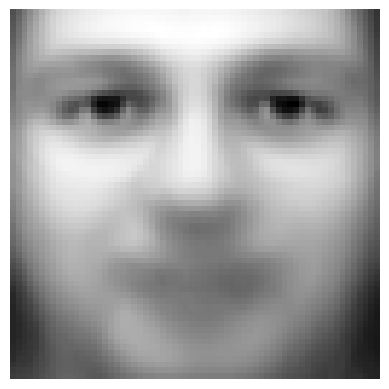

In [5]:
plt.imshow(mu.reshape(64, 64), cmap='gray')  # визуализируем "среднее" лицо
plt.axis('off')

In [6]:
Xc = X - mu  # центрируем данные
Xc.mean(axis=0)  # проверяем на корректность, результат должен быть близким к 0

array([-5.9232114e-08,  8.8512898e-08,  1.0833144e-07, ...,
       -6.1392782e-08, -2.2321939e-07, -9.1791151e-08], dtype=float32)

# Центрированная матрица данных как линейный оператор вариаций

После центрирования данных появляется матрица

$$
X_c =
\begin{bmatrix}
\hat{x}_1^T \\
\vdots \\
\hat{x}_n^T
\end{bmatrix}
\in \mathbb{R}^{n \times d},
\quad \hat{x}_i = x_i - \mu.
$$

С точки зрения линейной алгебры, матрица $X_c$ задает линейный оператор

$$
X_c : \mathbb{R}^d \rightarrow
\mathbb{R}^n.
$$

Действие оператора $X_c$ на вектор $v \in \mathbb{R}^d$ запишем явно:

$$
X_c v =
\begin{bmatrix}
\hat{x}_1^T v \\
\hat{x}_2^T v \\
\vdots \\
\hat{x}_n^T v
\end{bmatrix}
=
\begin{bmatrix}
\langle \hat{x}_1, v \rangle \\
\langle \hat{x}_2, v \rangle \\
\vdots \\
\langle \hat{x}_n, v ⟩\end{bmatrix}.
$$

$\langle \hat{x}_i, v\rangle$ (скалярное произведение) дословно означает - насколько сильно изображение $i$ отклоняется от среднего лица в направлении $v$.

Геометрически это означает, что $X_c$ кодирует вариации данных относительно центра масс: он измеряет, насколько сильно изображения изменяются вдоль заданного направления $v$.

В частности, норма $\|X_c v\|_2$ пропорциональна диспресии данных в направлении $v$.

Поэтому поиск направлений максимальной вариации данных сводится к анализу линейного оператора $X_c$ и его канонических форм.

## Постановка задачи метода главных компонент (PCA)

Теперь можно поставить задачу поиска главного направления - РСА.

Мы рассматриваем пространство признаков $\mathbb{R}^{4096}$, в котором каждое изображение лица представлено точкой $\hat{x}_i \in \mathbb{R}^{4096}$.

Каждая координата соответствует одному пикселю изображения.

Поскольку лица людей обладают общей структурой (глаза, нос, рот, симметрия), облако точек, соответствующее изображениям лиц, не заполняет пространство $\mathbb{R}^{4096}$ равномерно, а сосредоточено вблизи некоторого линейного подпространства.

В отличие от шума или произвольных изображений, лица лижат в значительно более низкоранговой области пространства признаков.

Задача метода главных компонент (РСА) состоит в нахождении линейного подпространства малой размерности (линии, плоскости, или $k$-мерного подпространства), которое наилучшим образом аппроксимирует это облако точек.

Формально, РСА ищет ортонормированные направления $v_1, \dots, v_k \in \mathbb{R}^{4096}$, такие что проекции центрированных данных на эти направления имеют максимальную дисперсию.

Для одного направления $v$ проекция изображения $\hat{x}_i$ задается скалярным произведением

$$
\alpha_i \langle \hat{x}_i, v \rangle,
$$

а вектор

$$
\alpha = X_c v
$$

содержит координаты всех изображений вдоль данного направления.

Максимизация нормы $\|\alpha\|^2 = \|X_c v\|^2$ эквивалентна поиску направления, вдоль которого данные обладают наибльшей вариацией.

Ограничение $\|v\| = 1$ устраняет неоднозначность маштабирования.

Таким образом, РСА сводится к задаче поиска оптимального линейного подпространства, в котором изображения лиц могут быть представлены с минимальной потерей информации.

## Сингулярное разложение линейного оператора центрированных данных

Центрированная матрица данных $X_c \in \mathbb{R}^{n \times d}$ может рассматриваться как линейный оператор

$$
X_c : \mathbb{R}^{d} \rightarrow \mathbb{R}^{n},
$$

который каждому направлению в пространстве признаков ставит в соответствие координаты всех изображений вдоль этого направления.

Сингулярное разложение (SVD) представляется в виде

$$
X_c = U \Sigma V^T,
$$

где:


- столбцы матрицы $V$ образуют ортонормированный базис пространства признаков $\mathbb{R}^d$;
- сингулярные значения $\sigma_i$ на диагонали $\Sigma$ упорядочены по убыванию и отражают энергию данных вдоль соответствующих направлений;
- столбцы матрицы $U$ содержат координаты изображений в новом базисе.

В контексте РСА столбцы матрицы $V$ совпадают с главными компонентами, а первые $k$ столбцов $V_k$ задают линейное подпространство, наилучшим образом аппроксимирующее облако изображений лиц.

## SVD центрированной матрицы и ее геометрический смысл

Пусть дана центрированная матрица данных

$$
X_c =
\begin{pmatrix}
x_1^T \\
x_2^T \\
\vdots \\
x_n^T
\end{pmatrix}
\in \mathbb{R}^{n \times d},
\qquad
x_i \in \mathbb{R}^d
$$

где каждая строка соответствует одному изображению (лицу), а данные центрированы, то есть

$$
\sum_{i=1}^n x_i = 0.
$$

### Сингулярное разложение

Сингулярное разложение матрицы $X_c$ имеет вид

$$
X_c = U \Sigma V^T,
$$

где:

- $V = [v_1, v_2, \dots, v_d] \in \mathbb{R}^{d \times d}$ - ортонормированный базис пространства признаков
- $\Sigma \in \mathbb{R}^{n \times d}$ - диагональная матрица сингулярных чисел,
- $U = [u_1, u_2, \dots, u_n] \in \mathbb{R}^{n \times n}$ - ортонормированный базис образа линейного оператора $X_c$.


### Матрица $V$: направления вариации (eigenfaces)

Каждый столбец $v_i \in \mathbb{R}^d$ — это направление в пространстве признаков, вдоль которого данные имеют убывающую дисперсию.

Эти векторы являются собственными векторами матрицы

$$
X_c^T X_c.
$$

Геометрически $v_i$ задаёт направление, вдоль которого изображения максимально различаются.


### Матрица $\Sigma$: величина вариации

Сингулярные числа

$$
\sigma_1 \ge \sigma_2 \ge \dots \ge \sigma_r > 0
$$

расположены на главной диагонали матрицы $\Sigma$.

Квадрат сингулярного числа $\sigma_i^2$ пропорционален дисперсии данных вдоль направления $v_i$.


### Матрица $U$: координаты всех лиц

Для каждого ненулевого сингулярного числа $\sigma_i$ соответствующий столбец матрицы $U$ вычисляется как

$$
u_i
=
\frac{1}{\sigma_i}
\begin{pmatrix}
\langle x_1, v_i \rangle \\
\langle x_2, v_i \rangle \\
\vdots \\
\langle x_n, v_i \rangle
\end{pmatrix}
\in \mathbb{R}^n.
$$

То есть каждая координата $u_i(j)$ - это нормированная проекция изображения $x_j$ на направление $v_i$.
Вектор $u_i$ описывает распределение всех лиц вдоль $i$-й главной компоненты.


### Геометрическая интерпретация (пример $\mathbb{R}^3$)

Рассмотрим случай, когда пространство признаков есть $\mathbb{R}^3$, но все изображения лежат в двумерном линейном подпространстве

$$
\Pi \subset \mathbb{R}^3,
$$

которое можно представить как лист бумаги.

Тогда:

- столбцы $v_1$ и $v_2$ матрицы $V$ лежат в подпространстве $\Pi$ и описывают основные направления вариации лиц:
  - вдоль $v_1$ рисунок на листе бумаги вытянут сильнее,
  - вдоль $v_2$ — слабее;
- столбец $v_3$ ортогонален $\Pi$ и представляет собой направление, не содержащее вариации данных (спица, прокалывающая лист бумаги).

Матрица $\Sigma$ в этом случае имеет вид

$$
\Sigma =
\begin{pmatrix}
\sigma_1 & 0 & 0 \\
0 & \sigma_2 & 0 \\
0 & 0 & 0
\end{pmatrix},
\qquad
\sigma_1 \ge \sigma_2 > 0,
$$

что отражает двумерную природу подпространства данных.


### Итог

- $V$ описывает *что* меняется в изображениях (направления вариации),
- $\Sigma$ - *насколько сильно* данные меняются вдоль этих направлений,
- $U$ - *как именно все изображения распределены* вдоль найденных направлений.

In [7]:
U, S, VT = np.linalg.svd(Xc, full_matrices=False)
V = VT.T

In [8]:
print("U:", U.shape)
print("S:", S.shape)  # S - важность направлений (дисперсия)
print("V:", V.shape)  # V - eigenfaces (направления в пространстве признаков)

# US - координаты лиц в PCA-пространстве

U: (400, 400)
S: (400,)
V: (4096, 400)


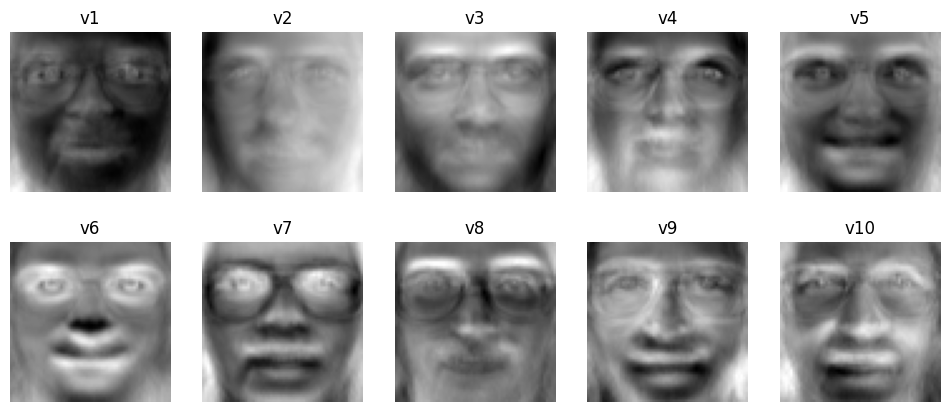

In [9]:
# Это и есть столбцы матрицы V - базис, в котором живут лица

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    eigenface = V[:, i].reshape(64, 64)
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f"v{i+1}")
    ax.axis('off')

plt.show()

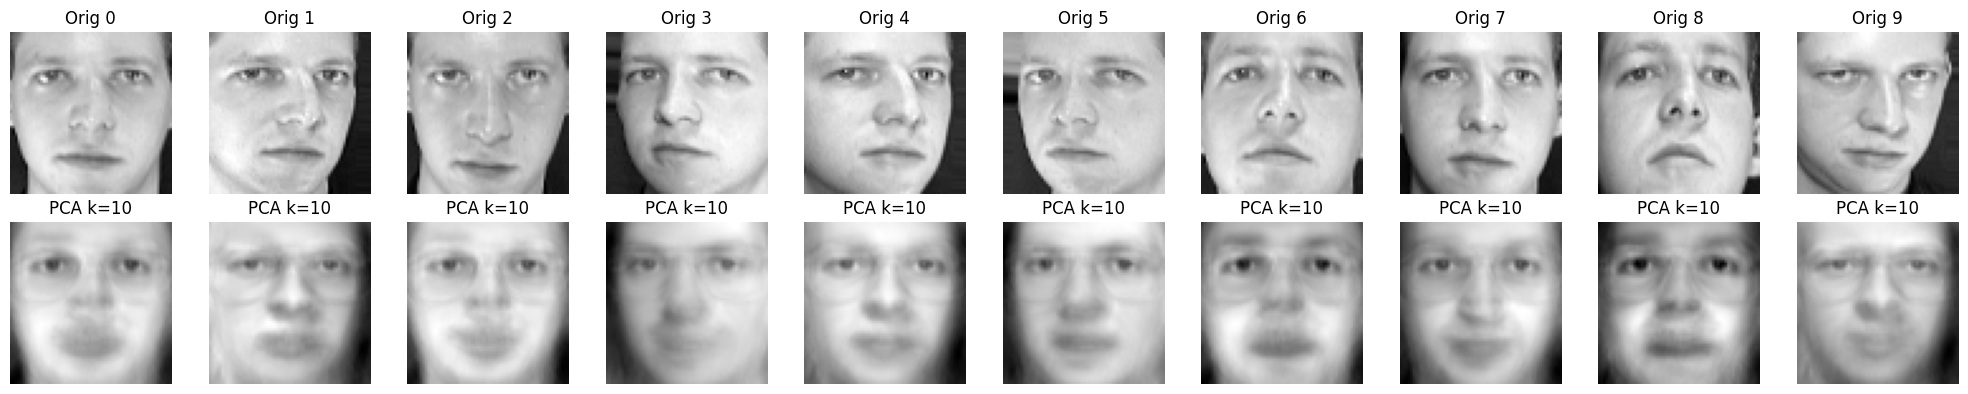

In [10]:
# сравнение оригиналов и PCA-реконструкций для 10 лиц при k = 10

k = 10
Z = Xc @ V[:, :k]   # (400, k); каждая строка Z[i] - координаты лица i в k-мерном пространстве

X_recon = Z @ V[:, :k].T + mu # востановление (сжатие)

num_images = 10
indices = np.arange(num_images)

fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

for i, idx in enumerate(indices):
    # оригинал
    axes[0, i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[0, i].set_title(f"Orig {idx}")
    axes[0, i].axis('off')

    # реконструкция
    axes[1, i].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
    axes[1, i].set_title(f"PCA k={k}")
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

plt.tight_layout()
plt.show()

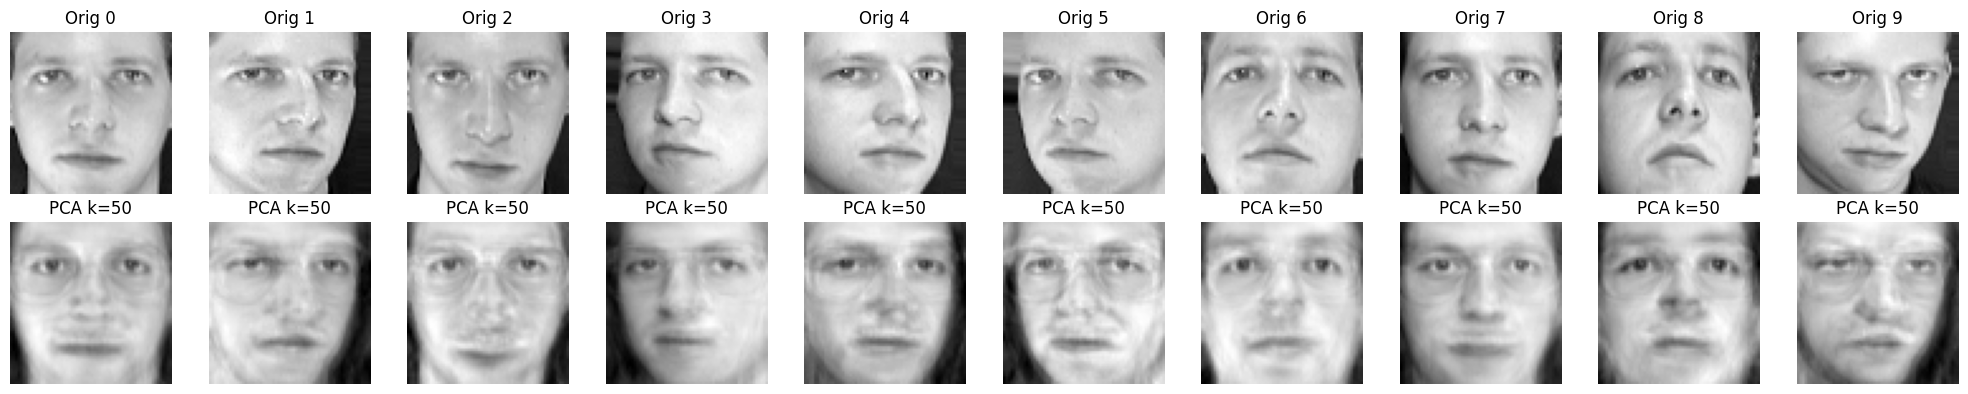

In [11]:
# сравнение оригиналов и PCA-реконструкций для 10 лиц при k = 50

k = 50
Z = Xc @ V[:, :k]   # (400, k); каждая строка Z[i] - координаты лица i в k-мерном пространстве

X_recon = Z @ V[:, :k].T + mu # востановление (сжатие)

num_images = 10
indices = np.arange(num_images)

fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

for i, idx in enumerate(indices):
    # оригинал
    axes[0, i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[0, i].set_title(f"Orig {idx}")
    axes[0, i].axis('off')

    # реконструкция
    axes[1, i].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
    axes[1, i].set_title(f"PCA k={k}")
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

plt.tight_layout()
plt.show()

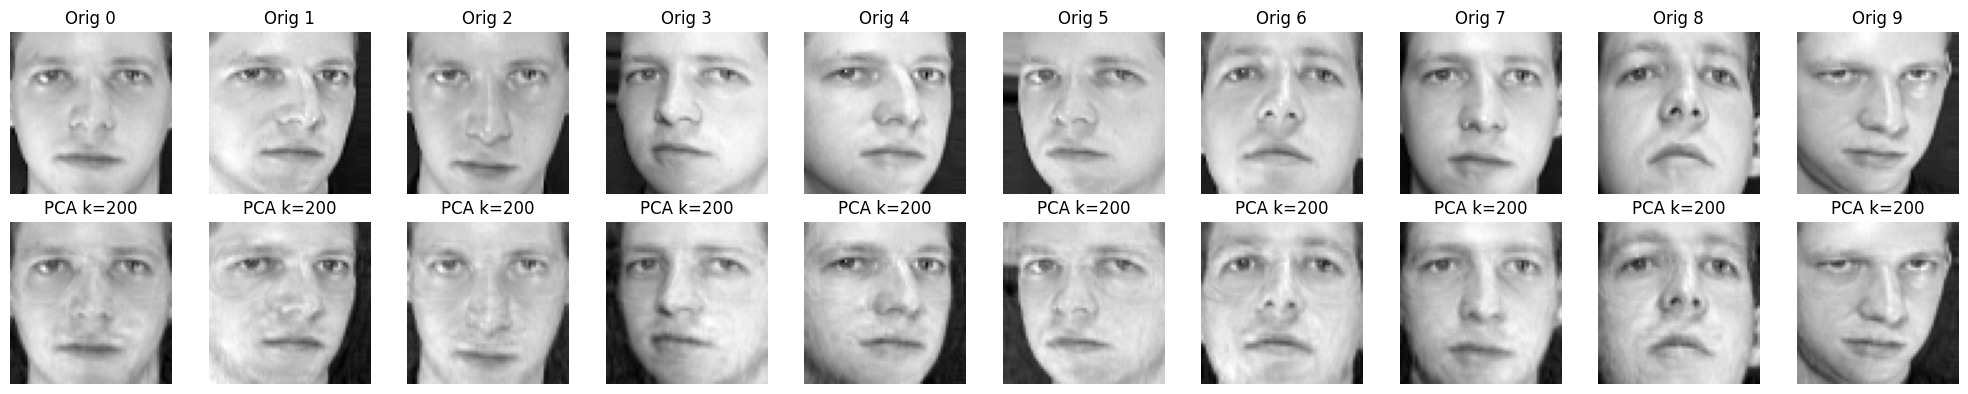

In [12]:
# сравнение оригиналов и PCA-реконструкций для 10 лиц при k = 200

k = 200
Z = Xc @ V[:, :k]   # (400, k); каждая строка Z[i] - координаты лица i в k-мерном пространстве

X_recon = Z @ V[:, :k].T + mu # востановление (сжатие)

num_images = 10
indices = np.arange(num_images)

fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

for i, idx in enumerate(indices):
    # оригинал
    axes[0, i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[0, i].set_title(f"Orig {idx}")
    axes[0, i].axis('off')

    # реконструкция
    axes[1, i].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
    axes[1, i].set_title(f"PCA k={k}")
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# пишем свою реализацию РСА - для работы с другими датасетами

def my_pca(X, k):
    """
    Реализация метода главных компонент (PCA) через SVD.

    Параметры
    ----------
    X : ndarray формы (n, d)
        Матрица данных:
        n — число изображений (лиц),
        d — число признаков (пикселей).
        Каждая строка X[i] — вектор изображения x^i ∈ R^d.

    k : int
        Число главных компонент (размерность искомого подпространства).

    Возвращает
    ----------
    mu : ndarray формы (d,)
        Средний вектор (среднее лицо) μ ∈ R^d.

    V_k : ndarray формы (d, k)
        Матрица из k главных компонент.
        Столбцы — ортонормированные направления максимальной вариации (eigenfaces).

    Z : ndarray формы (n, k)
        Координаты изображений в PCA-пространстве.
        Каждая строка Z[i] — координаты лица i вдоль главных направлений.

    X_recon : ndarray формы (n, d)
        Восстановленные изображения из k-мерного подпространства.
    """

    # 1. Вычисляем средний вектор (центр масс облака точек)
    #    μ = (1/n) * Σ x^i
    mu = X.mean(axis=0)

    # 2. Центрируем данные:
    #    переходим от аффинного подпространства к линейному
    #    x^i → x^i - μ
    Xc = X - mu

    # 3. Сингулярное разложение центрированной матрицы данных
    #    Xc рассматривается как линейный оператор:
    #    Xc : R^d → R^n
    #
    #    Xc = U Σ V^T
    U, S, VT = np.linalg.svd(Xc, full_matrices=False)

    # 4. Матрица V содержит ортонормированные направления
    #    в пространстве признаков (главные компоненты)
    V = VT.T

    # 5. Выбираем первые k главных направлений
    #    Они соответствуют наибольшим сингулярным числам
    V_k = V[:, :k]

    # 6. Проекция данных на k-мерное PCA-подпространство
    #    Z_ij = ⟨ x^i - μ , v_j ⟩
    Z = Xc @ V_k

    # 7. Восстановление данных из PCA-пространства
    #    x̂^i = μ + Σ_j Z_ij v_j
    X_recon = Z @ V_k.T + mu

    return mu, V_k, Z, X_recon

Форма матрицы данных X: (2000, 784)


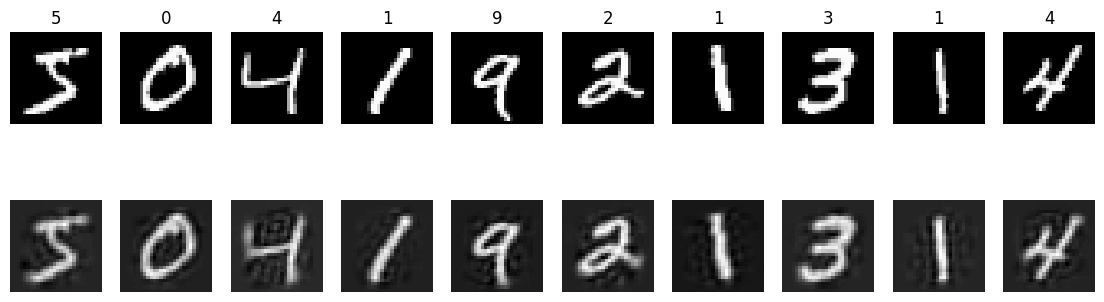

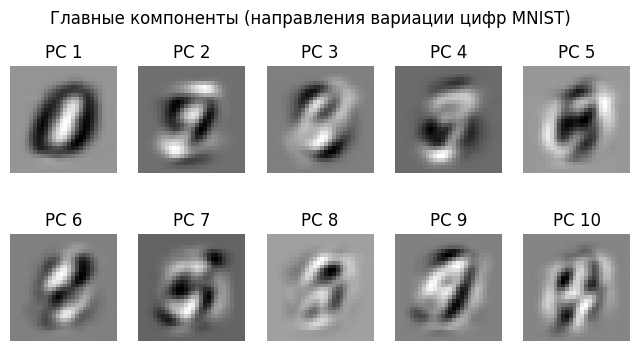

In [14]:
# PCA на датасете MNIST (чёткие рукописные цифры 28x28)

# --------------------------------------------------
# 1. Загружаем датасет MNIST
# --------------------------------------------------
# Каждое изображение: 28x28 = 784 признака
(X_train, y_train), _ = mnist.load_data()

# Возьмём подмножество, чтобы PCA считалась быстрее
X = X_train[:2000]
y = y_train[:2000]

# Преобразуем изображения в векторы
X = X.reshape(len(X), -1)

# Нормализуем значения пикселей в [0, 1]
X = X / 255.0

print("Форма матрицы данных X:", X.shape)

# --------------------------------------------------
# 2. Применяем PCA
# --------------------------------------------------
k = 100  # 784 → 100 (сильное сжатие)

mu, V_k, Z, X_recon = my_pca(X, k)

# --------------------------------------------------
# 3. Сравнение: оригинал vs восстановление
# --------------------------------------------------
n_show = 10

fig, axes = plt.subplots(2, n_show, figsize=(14, 4))

for i in range(n_show):
    # Оригинал
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"{y[i]}")
    axes[0, i].axis('off')

    # Восстановление через PCA
    axes[1, i].imshow(X_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel(f"PCA (k={k})", fontsize=12)

plt.show()

# --------------------------------------------------
# 4. Визуализация главных компонент (eigen-цифры)
# --------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(8, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(V_k[:, i].reshape(28, 28), cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')

plt.suptitle("Главные компоненты (направления вариации цифр MNIST)")
plt.show()

Форма X: (400, 4096)


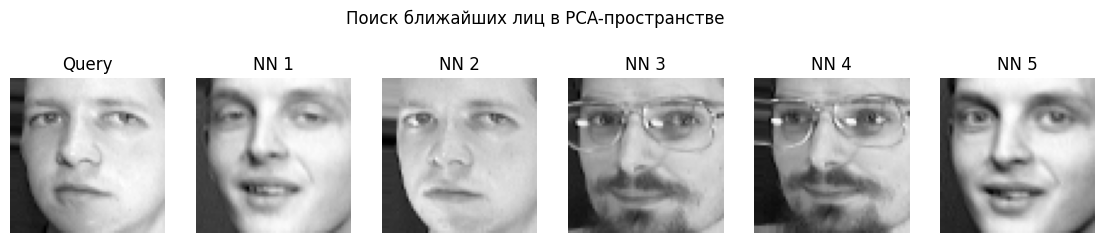

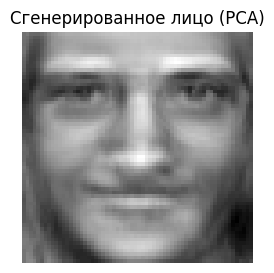

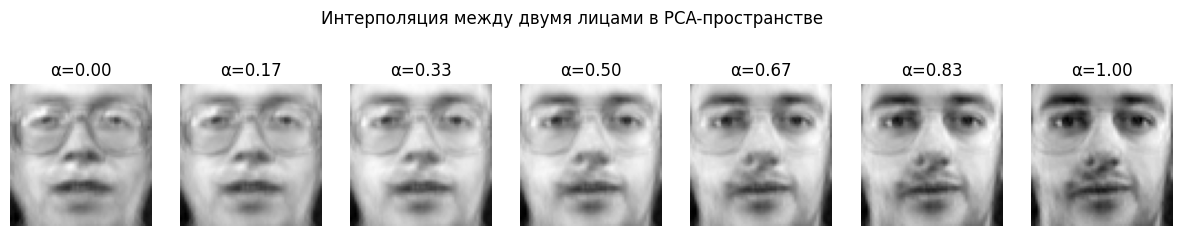

In [15]:
# PCA: поиск похожих лиц и генерация новых (Olivetti Faces)

# --------------------------------------------------
# 1. Загружаем датасет Olivetti Faces
# --------------------------------------------------
data = fetch_olivetti_faces()

X = data.data          # (400, 4096)
images = data.images   # (400, 64, 64)

h, w = images.shape[1:]

print("Форма X:", X.shape)

# --------------------------------------------------
# 2. Обучаем PCA на лицах
# --------------------------------------------------
k = 50  # размерность подпространства лиц

mu, V_k, Z, X_recon = my_pca(X, k)

# --------------------------------------------------
# 3. ПОИСК БЛИЖАЙШИХ СОСЕДЕЙ (kNN в PCA-пространстве)
# --------------------------------------------------

# Берём одно лицо как запрос
query_idx = 3
z_query = Z[query_idx].reshape(1, -1)

# Евклидовы расстояния в PCA-пространстве
distances = euclidean_distances(z_query, Z)[0]

# Индексы 5 ближайших соседей (кроме самого себя)
nn_indices = np.argsort(distances)[1:6]

# Визуализация
fig, axes = plt.subplots(1, 6, figsize=(14, 3))

axes[0].imshow(images[query_idx], cmap='gray')
axes[0].set_title("Query")
axes[0].axis('off')

for i, idx in enumerate(nn_indices):
    axes[i+1].imshow(images[idx], cmap='gray')
    axes[i+1].set_title(f"NN {i+1}")
    axes[i+1].axis('off')

plt.suptitle("Поиск ближайших лиц в PCA-пространстве")
plt.show()

# --------------------------------------------------
# 4. ГЕНЕРАЦИЯ НОВОГО ЛИЦА (случайная комбинация признаков)
# --------------------------------------------------

# Средние и дисперсии коэффициентов PCA
z_mean = Z.mean(axis=0)
z_std = Z.std(axis=0)

# Случайный вектор коэффициентов
z_random = np.random.normal(z_mean, z_std)

# Восстанавливаем лицо
x_generated = z_random @ V_k.T + mu

plt.figure(figsize=(3, 3))
plt.imshow(x_generated.reshape(h, w), cmap='gray')
plt.title("Сгенерированное лицо (PCA)")
plt.axis('off')
plt.show()

# --------------------------------------------------
# 5. ИНТЕРПОЛЯЦИЯ МЕЖДУ ДВУМЯ ЛИЦАМИ
# --------------------------------------------------

idx1, idx2 = 10, 150
z1, z2 = Z[idx1], Z[idx2]

alphas = np.linspace(0, 1, 7)

fig, axes = plt.subplots(1, len(alphas), figsize=(15, 3))

for i, a in enumerate(alphas):
    z_interp = (1 - a) * z1 + a * z2
    x_interp = z_interp @ V_k.T + mu

    axes[i].imshow(x_interp.reshape(h, w), cmap='gray')
    axes[i].set_title(f"α={a:.2f}")
    axes[i].axis('off')

plt.suptitle("Интерполяция между двумя лицами в PCA-пространстве")
plt.show()

# Итоги: PCA как геометрия данных, поиск и генерация лиц

В этом ноутбуке метод главных компонент (PCA) был рассмотрен не как алгоритм,
а как следствие линейной алгебры и геометрии данных.

---

## Линейная алгебра (Jean Gallier)

Следуя книге  
**Jean Gallier — *Linear Algebra for Computer Vision, Robotics, and Machine Learning**,  
мы рассматривали центрированную матрицу данных

$$
X_c \in \mathbb{R}^{n \times d}
$$

как линейный оператор

$$
X_c : \mathbb{R}^d \to \mathbb{R}^n,
$$

который каждому направлению в пространстве признаков сопоставляет координаты
всех изображений вдоль этого направления.

Галье подчёркивает, что:

> «Сингулярное разложение предоставляет каноническую форму линейного оператора,
> раскрывающую его геометрию и структуру вариаций данных».

Сингулярное разложение

$$
X_c = U \Sigma V^T
$$

позволяет:

- выявить ортонормированные направления максимальной вариации (столбцы $V$);
- измерить важность этих направлений (сингулярные числа $\Sigma$);
- представить каждое изображение в новых координатах (матрица $U$).

---

## Интуитивное объяснение

Каждое изображение лица — это точка в пространстве $\mathbb{R}^{4096}$.

Из-за общей структуры человеческих лиц (глаза, нос, рот, симметрия)
эти точки не заполняют пространство равномерно, а лежат вблизи
низкоразмерного линейного подпространства.

PCA ищет такие направления, вдоль которых:

- лица отличаются друг от друга сильнее всего;
- вариации данных максимальны;
- информация может быть сжата с минимальными потерями.

Геометрически это означает:
мы поворачиваем систему координат так, чтобы оси совпали с «главными» направлениями облака лиц.

---

## Что мы сделали на практике

В этом ноутбуке мы:

### 1. Сжали изображения
Используя первые \(k\) главных компонент, мы восстановили лица,
сохранив большую часть визуальной информации при значительном уменьшении размерности.

### 2. Нашли похожие лица
В пространстве PCA близость между изображениями измеряется
обычным евклидовым расстоянием между коэффициентами проекции.

Это позволяет эффективно находить похожие лица,
избавившись от шума и несущественных деталей.

### 3. Сгенерировали новые лица
Линейные комбинации коэффициентов PCA позволяют:

- интерполировать между лицами;
- создавать новые изображения, лежащие в том же подпространстве;
- исследовать геометрию «пространства лиц».

Такие сгенерированные изображения не являются фотографиями реальных людей,
но сохраняют характерные черты человеческого лица.

---

## Заключение

PCA - это не просто метод уменьшения размерности.

Это:

- геометрическое описание данных;
- каноническая форма линейного оператора;
- мост между линейной алгеброй и реальными изображениями.

Этот ноутбук показывает,
как строгие математические идеи напрямую приводят
к поиску похожих объектов, сжатию данных и генерации новых примеров.

В дальнейшем линейную модель PCA можно расширять
с помощью нелинейных автоэнкодеров и вариационных моделей,
но фундамент геометрии данных остаётся тем же.

---

In [16]:
# для сравнения оригинала и восстановленного изображения

# папка для сохранения
base_path = "photos"
os.makedirs(base_path, exist_ok=True)

# сколько изображений сохраняем
n_samples = 10

# случайные индексы
indices = np.random.choice(len(X), size=n_samples, replace=False)

for i, idx in enumerate(indices):
    # оригинальное изображение
    img_orig = X[idx].reshape(64, 64)
    plt.imsave(
        f"{base_path}/face_{i+1:02d}_original.png",
        img_orig,
        cmap="gray"
    )

    # восстановленное изображение
    img_recon = X_recon[idx].reshape(64, 64)
    plt.imsave(
        f"{base_path}/face_{i+1:02d}_pca_k{k}.png",
        img_recon,
        cmap="gray"
    )